In [1]:
# =============================================================================
# STEP 1: LOAD DATASET A
# =============================================================================

# Import pandas - a library for working with tabular data (like spreadsheets)
import pandas as pd

# Load the CSV file into a DataFrame (a table structure)
# Dataset A has "equal covariance" - meaning the spread of data is similar for each class
df = pd.read_csv("datasetA.csv")

# =============================================================================
# STEP 2: VERIFY THE DATASET
# =============================================================================

# Check the number of rows using .shape[0]
# .shape returns (rows, columns), so [0] gets just the row count
# Expected: 1000 rows
print(f"Number of rows: {df.shape[0]}")

# Check the column names to ensure data loaded correctly
# Expected: x1, x2 (the two features) and label (the class: 0 or 1)
print(f"Column names: {list(df.columns)}")

# Display the first 5 rows to visually inspect the data
# .head() shows a preview without printing the entire dataset
df.head()

Number of rows: 1000
Column names: ['x1', 'x2', 'label']


,x1,x2,label
0,2.304717,1.960016,0
1,2.750451,3.940565,0
2,0.048965,1.697820,0
3,2.127840,2.683757,0
4,1.983199,2.146956,0


In [2]:
# =============================================================================
# STEP 3: STRATIFIED 80/20 TRAIN/TEST SPLIT
# =============================================================================

# Import numpy for random number generation
import numpy as np

# What is a stratified split?
# - "Stratified" means each class (0 and 1) is split proportionally
# - If class 0 has 500 samples, 80% (400) go to train, 20% (100) go to test
# - This ensures both train and test sets have balanced class representation

# Why stratified?
# - Prevents all samples of one class ending up in train or test by chance
# - Gives a fair evaluation of model performance on both classes

# Function: stratified_train_test_split
# Split data into train and test sets, keeping class proportions equal.
#
# Parameters:
# - df: the DataFrame to split
# - test_frac: fraction of data for testing (0.2 = 20%)
# - random_state: seed for reproducibility (same split every time)
def stratified_train_test_split(df, test_frac=0.2, random_state=42):
    # Set random seed so results are reproducible
    rng = np.random.default_rng(random_state)

    # Lists to store indices for train and test sets
    train_idx, test_idx = [], []

    # Loop through each class (label 0 and label 1) separately
    for cls, group in df.groupby("label"):
        # Get all row indices for this class
        idx = group.index.to_numpy()

        # Shuffle the indices randomly
        rng.shuffle(idx)

        # Calculate how many samples go to test set (20%)
        n_test = int(len(idx) * test_frac)

        # First n_test indices go to test, the rest go to train
        test_idx.extend(idx[:n_test])
        train_idx.extend(idx[n_test:])

    # Create the train and test DataFrames using the collected indices
    train_df = df.loc[sorted(train_idx)].reset_index(drop=True)
    test_df = df.loc[sorted(test_idx)].reset_index(drop=True)

    return train_df, test_df

# Perform the split: 80% train, 20% test
train_df, test_df = stratified_train_test_split(df, test_frac=0.2)

# =============================================================================
# VERIFY THE SPLIT
# =============================================================================

# Check the sizes of each set
print(f"Training set size: {len(train_df)} rows (80%)")
print(f"Test set size: {len(test_df)} rows (20%)")

# Verify stratification - check class distribution in each set
print(f"\nTraining set class distribution:")
print(train_df["label"].value_counts().sort_index())

print(f"\nTest set class distribution:")
print(test_df["label"].value_counts().sort_index())


Training set size: 800 rows (80%)
Test set size: 200 rows (20%)

Training set class distribution:
label
0    400
1    400
Name: count, dtype: int64

Test set class distribution:
label
0    100
1    100
Name: count, dtype: int64


In [3]:
# =============================================================================
# STEP 4: COMPUTE CLASS MEAN VECTORS
# =============================================================================

# What are class mean vectors?
# - The "mean" (average) position of all points belonging to each class
# - For class 0: average of all x1 values, average of all x2 values = (mu0_x1, mu0_x2)
# - For class 1: average of all x1 values, average of all x2 values = (mu1_x1, mu1_x2)
# - These are the "centroids" (center points) of each class

# Why use only training data?
# - Test data must remain unseen during model training
# - Using test data would be "cheating" - the model would have seen the answers
# - This ensures a fair evaluation of the model's performance

# Calculate the mean of x1 and x2 for each class (0 and 1) in training data
# .groupby("label") - separates data by class
# [["x1","x2"]] - selects only the feature columns
# .mean() - calculates the average of each column per group
means = train_df.groupby("label")[["x1", "x2"]].mean()

# Display the class means
print("Class mean vectors (centroids):")
print(means)

# Extract individual mean vectors for clarity
mu0 = means.loc[0].values  # Mean vector for class 0: [x1_mean, x2_mean]
mu1 = means.loc[1].values  # Mean vector for class 1: [x1_mean, x2_mean]

print(f"\nmu0 (class 0 centroid): x1={mu0[0]:.4f}, x2={mu0[1]:.4f}")
print(f"mu1 (class 1 centroid): x1={mu1[0]:.4f}, x2={mu1[1]:.4f}")


Class mean vectors (centroids):
             x1        x2
label                    
0      1.994434  2.948663
1      5.883596  6.946654

mu0 (class 0 centroid): x1=1.9944, x2=2.9487
mu1 (class 1 centroid): x1=5.8836, x2=6.9467


In [4]:
# =============================================================================
# STEP 5: NEAREST-CLASS-MEAN (NCM) CLASSIFIER
# =============================================================================

# What is the Nearest-Class-Mean classifier?
# - A simple classification method based on distance to class centroids
# - For each test point, calculate distance to mu0 and distance to mu1
# - Assign the point to whichever class centroid is closer

# What is Euclidean distance?
# - The straight-line distance between two points
# - For 2D points: distance = sqrt((x1_a - x1_b)^2 + (x2_a - x2_b)^2)
# - Example: distance from (0,0) to (3,4) = sqrt(9 + 16) = sqrt(25) = 5

# Function: nearest_mean_predict
# Predicts class labels for test data using nearest class mean
#
# Parameters:
# - test_df: DataFrame containing test samples with x1, x2 columns
# - means: DataFrame containing mean vectors for each class
def nearest_mean_predict(test_df, means):
    # Get the centroid coordinates as a numpy array
    # Shape: (2, 2) - 2 classes, each with 2 coordinates (x1, x2)
    centers = means.values

    # Get the class labels (0 and 1) in the same order as centers
    labels = means.index.to_numpy()

    # Get test point coordinates as numpy array
    # Shape: (n_samples, 2) - each row is a point with x1, x2
    X = test_df[["x1", "x2"]].to_numpy()

    # Calculate squared Euclidean distance from each test point to each centroid
    # X[:, None, :] reshapes X to (n_samples, 1, 2) for broadcasting
    # centers[None, :, :] reshapes centers to (1, 2, 2) for broadcasting
    # Result shape: (n_samples, 2) - distance to each of the 2 centroids
    # Note: we use squared distance (no sqrt) because it preserves ordering
    dists = np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2)

    # For each test point, find which centroid is closest (index 0 or 1)
    pred_idx = np.argmin(dists, axis=1)

    # Convert centroid indices back to class labels
    return labels[pred_idx]

# Run the classifier on test data
y_pred = nearest_mean_predict(test_df, means)

# Display some predictions alongside actual labels
print("Sample predictions (first 10 test points):")
print(f"Predicted: {y_pred[:10]}")
print(f"Actual:    {test_df['label'].values[:10]}")


Sample predictions (first 10 test points):
Predicted: [0 0 0 0 0 0 0 0 0 0]
Actual:    [0 0 0 0 0 0 0 0 0 0]


In [5]:
# =============================================================================
# STEP 6: EVALUATE TEST ACCURACY
# =============================================================================

# What is accuracy?
# - The proportion of correct predictions out of all predictions
# - Formula: accuracy = (number correct) / (total predictions)
# - Example: 180 correct out of 200 = 180/200 = 0.90 = 90%

# Get the actual labels from test data
y_true = test_df["label"].to_numpy()

# Calculate accuracy by comparing predictions to actual labels
# (y_true == y_pred) creates array of True/False for each prediction
# .mean() calculates proportion of True values (correct predictions)
accuracy = (y_true == y_pred).mean()

# Display the results
print("=" * 50)
print("DATASET A - NCM CLASSIFIER RESULTS")
print("=" * 50)
print(f"Total test samples: {len(y_true)}")
print(f"Correct predictions: {(y_true == y_pred).sum()}")
print(f"Incorrect predictions: {(y_true != y_pred).sum()}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
print("=" * 50)

# =============================================================================
# OPTIONAL: SAVE PREDICTIONS TO CSV
# =============================================================================

# Create a DataFrame with test data and predictions for review
results_df = test_df.copy()
results_df["predicted"] = y_pred
results_df["correct"] = (y_true == y_pred)

# Save to CSV file
results_df.to_csv("datasetA_predictions.csv", index=False)
print("\nPredictions saved to: datasetA_predictions.csv")

# Show a few incorrect predictions for analysis
incorrect = results_df[results_df["correct"] == False]
print(f"\nIncorrect predictions ({len(incorrect)} total):")
print(incorrect.head(10))


DATASET A - NCM CLASSIFIER RESULTS
Total test samples: 200
Correct predictions: 200
Incorrect predictions: 0
Test Accuracy: 1.0000 (100.00%)

Predictions saved to: datasetA_predictions.csv

Incorrect predictions (0 total):
Empty DataFrame
Columns: [x1, x2, label, predicted, correct]
Index: []


In [6]:
# =============================================================================
# DATASET B - COMPLETE NCM CLASSIFICATION PIPELINE
# =============================================================================
# This repeats the same process as Dataset A, but for Dataset B
# Dataset B has "unequal covariance" - the spread of data differs between classes

import pandas as pd
import numpy as np

# =============================================================================
# STEP 1: LOAD DATASET B
# =============================================================================

# Load Dataset B (unequal covariance)
df_b = pd.read_csv("datasetB.csv")

# Verify the dataset
print("DATASET B - LOADING")
print(f"Number of rows: {df_b.shape[0]}")
print(f"Column names: {list(df_b.columns)}")
print(df_b.head())

# =============================================================================
# STEP 2: STRATIFIED 80/20 SPLIT
# =============================================================================

def stratified_train_test_split(df, test_frac=0.2, random_state=42):
    # Set random seed so results are reproducible
    rng = np.random.default_rng(random_state)
    train_idx, test_idx = [], []

    # Split each class proportionally
    for cls, group in df.groupby("label"):
        idx = group.index.to_numpy()
        rng.shuffle(idx)
        n_test = int(len(idx) * test_frac)
        test_idx.extend(idx[:n_test])
        train_idx.extend(idx[n_test:])

    train_df = df.loc[sorted(train_idx)].reset_index(drop=True)
    test_df = df.loc[sorted(test_idx)].reset_index(drop=True)
    return train_df, test_df

# Perform the split
train_df_b, test_df_b = stratified_train_test_split(df_b, test_frac=0.2)

print("\nDATASET B - SPLIT VERIFICATION")
print(f"Training set size: {len(train_df_b)} rows")
print(f"Test set size: {len(test_df_b)} rows")

# =============================================================================
# STEP 3: COMPUTE CLASS MEANS
# =============================================================================

# Calculate mean vectors from training data only
means_b = train_df_b.groupby("label")[["x1", "x2"]].mean()

print("\nDATASET B - CLASS MEANS")
print(means_b)

# =============================================================================
# STEP 4: NCM CLASSIFIER
# =============================================================================

def nearest_mean_predict(test_df, means):
    centers = means.values
    labels = means.index.to_numpy()
    X = test_df[["x1", "x2"]].to_numpy()

    # Calculate squared Euclidean distance to each centroid
    dists = np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2)

    # Predict class with nearest centroid
    pred_idx = np.argmin(dists, axis=1)
    return labels[pred_idx]

# Make predictions
y_pred_b = nearest_mean_predict(test_df_b, means_b)

# =============================================================================
# STEP 5: EVALUATE ACCURACY
# =============================================================================

y_true_b = test_df_b["label"].to_numpy()
accuracy_b = (y_true_b == y_pred_b).mean()

print("\n" + "=" * 50)
print("DATASET B - NCM CLASSIFIER RESULTS")
print("=" * 50)
print(f"Total test samples: {len(y_true_b)}")
print(f"Correct predictions: {(y_true_b == y_pred_b).sum()}")
print(f"Incorrect predictions: {(y_true_b != y_pred_b).sum()}")
print(f"Test Accuracy: {accuracy_b:.4f} ({accuracy_b * 100:.2f}%)")
print("=" * 50)

# Save predictions
results_df_b = test_df_b.copy()
results_df_b["predicted"] = y_pred_b
results_df_b["correct"] = (y_true_b == y_pred_b)
results_df_b.to_csv("datasetB_predictions.csv", index=False)
print("\nPredictions saved to: datasetB_predictions.csv")


DATASET B - LOADING
Number of rows: 1000
Column names: ['x1', 'x2', 'label']
         x1        x2  label
0  1.841817  2.766943      0
1  2.151903  3.088149      0
2  1.508323  3.392937      0
3  1.967032  2.611174      0
4  2.416074  3.218986      0

DATASET B - SPLIT VERIFICATION
Training set size: 800 rows
Test set size: 200 rows

DATASET B - CLASS MEANS
             x1        x2
label                    
0      2.011535  3.003682
1      5.928327  7.018540

DATASET B - NCM CLASSIFIER RESULTS
Total test samples: 200
Correct predictions: 197
Incorrect predictions: 3
Test Accuracy: 0.9850 (98.50%)

Predictions saved to: datasetB_predictions.csv


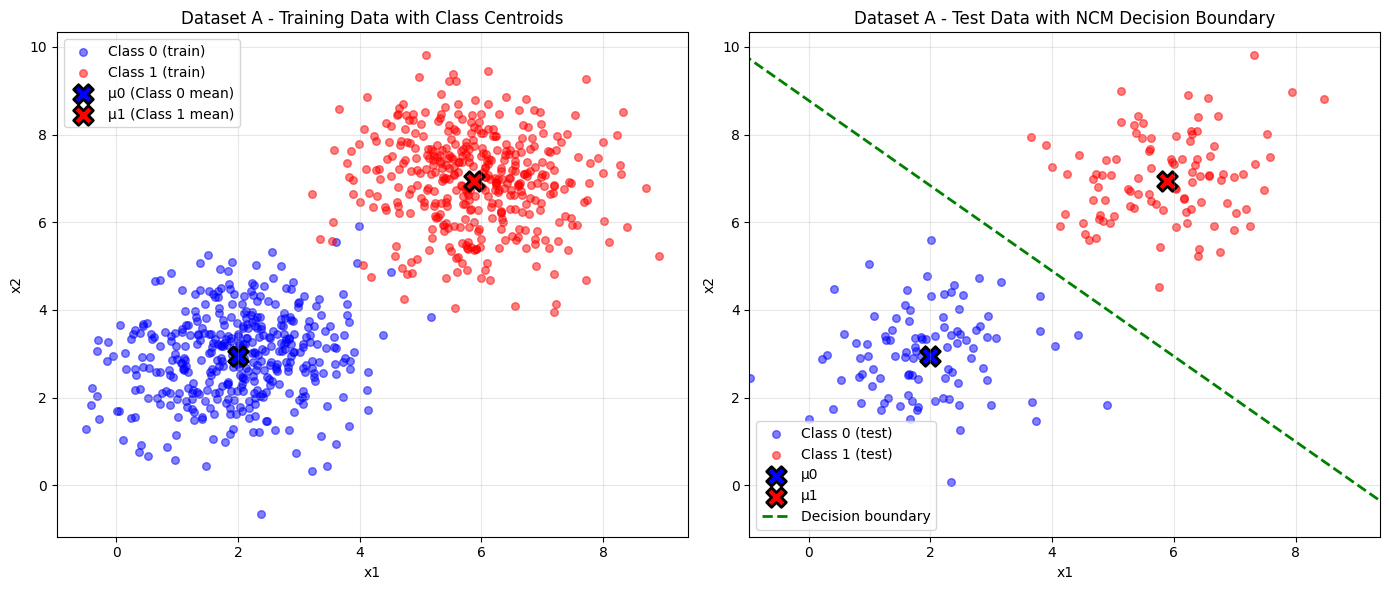

Plot saved to: datasetA_visualisation.png


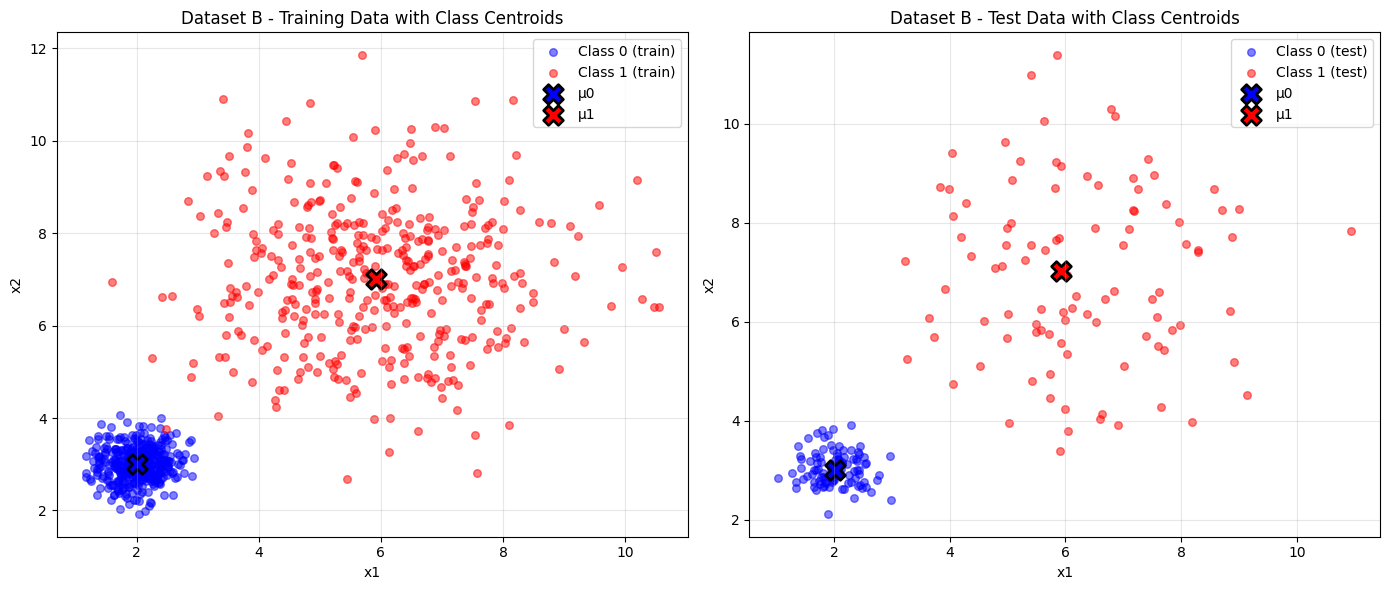

Plot saved to: datasetB_visualisation.png


In [7]:
# =============================================================================
# STEP 7: VISUALISATION
# =============================================================================

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# =============================================================================
# PLOT 1: DATASET A (EQUAL COVARIANCE) WITH DECISION BOUNDARY
# =============================================================================

# Create a figure with 1 row, 2 columns (side by side plots)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Left plot: Training data with centroids ---
ax1 = axes[0]

# Scatter plot of training data, colored by class
# Class 0 = blue, Class 1 = red
train_class0 = train_df[train_df["label"] == 0]
train_class1 = train_df[train_df["label"] == 1]

ax1.scatter(train_class0["x1"], train_class0["x2"], c="blue", alpha=0.5, label="Class 0 (train)", s=30)
ax1.scatter(train_class1["x1"], train_class1["x2"], c="red", alpha=0.5, label="Class 1 (train)", s=30)

# Plot the centroids (mean vectors) as large markers
mu0 = means.loc[0].values
mu1 = means.loc[1].values
ax1.scatter(mu0[0], mu0[1], c="blue", marker="X", s=200, edgecolor="black", linewidth=2, label="μ0 (Class 0 mean)")
ax1.scatter(mu1[0], mu1[1], c="red", marker="X", s=200, edgecolor="black", linewidth=2, label="μ1 (Class 1 mean)")

ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_title("Dataset A - Training Data with Class Centroids")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Right plot: Test data with decision boundary ---
ax2 = axes[1]

# Scatter plot of test data, colored by class
test_class0 = test_df[test_df["label"] == 0]
test_class1 = test_df[test_df["label"] == 1]

ax2.scatter(test_class0["x1"], test_class0["x2"], c="blue", alpha=0.5, label="Class 0 (test)", s=30)
ax2.scatter(test_class1["x1"], test_class1["x2"], c="red", alpha=0.5, label="Class 1 (test)", s=30)

# Plot centroids
ax2.scatter(mu0[0], mu0[1], c="blue", marker="X", s=200, edgecolor="black", linewidth=2, label="μ0")
ax2.scatter(mu1[0], mu1[1], c="red", marker="X", s=200, edgecolor="black", linewidth=2, label="μ1")

# =============================================================================
# NCM DECISION BOUNDARY (for equal covariance)
# =============================================================================
# The decision boundary is the perpendicular bisector of the line connecting μ0 and μ1
# Points on this line are equidistant from both centroids
#
# Math: The boundary is where distance to μ0 = distance to μ1
# This simplifies to a straight line perpendicular to the line joining the centroids

# Midpoint between the two centroids
midpoint = (mu0 + mu1) / 2

# Direction vector from μ0 to μ1
direction = mu1 - mu0

# Perpendicular direction (rotate 90 degrees by swapping and negating)
perpendicular = np.array([-direction[1], direction[0]])

# Create points along the decision boundary line
# Line equation: midpoint + t * perpendicular (for various values of t)
t_values = np.linspace(-3, 3, 100)
boundary_x = midpoint[0] + t_values * perpendicular[0]
boundary_y = midpoint[1] + t_values * perpendicular[1]

# Plot the decision boundary
ax2.plot(boundary_x, boundary_y, "g--", linewidth=2, label="Decision boundary")

# Set axis limits to match the data range
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_title("Dataset A - Test Data with NCM Decision Boundary")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("datasetA_visualisation.png", dpi=150)
plt.show()

print("Plot saved to: datasetA_visualisation.png")

# =============================================================================
# PLOT 2: DATASET B (UNEQUAL COVARIANCE)
# =============================================================================

fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))

# --- Left plot: Training data ---
ax3 = axes2[0]

train_class0_b = train_df_b[train_df_b["label"] == 0]
train_class1_b = train_df_b[train_df_b["label"] == 1]

ax3.scatter(train_class0_b["x1"], train_class0_b["x2"], c="blue", alpha=0.5, label="Class 0 (train)", s=30)
ax3.scatter(train_class1_b["x1"], train_class1_b["x2"], c="red", alpha=0.5, label="Class 1 (train)", s=30)

# Plot centroids
mu0_b = means_b.loc[0].values
mu1_b = means_b.loc[1].values
ax3.scatter(mu0_b[0], mu0_b[1], c="blue", marker="X", s=200, edgecolor="black", linewidth=2, label="μ0")
ax3.scatter(mu1_b[0], mu1_b[1], c="red", marker="X", s=200, edgecolor="black", linewidth=2, label="μ1")

ax3.set_xlabel("x1")
ax3.set_ylabel("x2")
ax3.set_title("Dataset B - Training Data with Class Centroids")
ax3.legend()
ax3.grid(True, alpha=0.3)

# --- Right plot: Test data ---
ax4 = axes2[1]

test_class0_b = test_df_b[test_df_b["label"] == 0]
test_class1_b = test_df_b[test_df_b["label"] == 1]

ax4.scatter(test_class0_b["x1"], test_class0_b["x2"], c="blue", alpha=0.5, label="Class 0 (test)", s=30)
ax4.scatter(test_class1_b["x1"], test_class1_b["x2"], c="red", alpha=0.5, label="Class 1 (test)", s=30)

# Plot centroids
ax4.scatter(mu0_b[0], mu0_b[1], c="blue", marker="X", s=200, edgecolor="black", linewidth=2, label="μ0")
ax4.scatter(mu1_b[0], mu1_b[1], c="red", marker="X", s=200, edgecolor="black", linewidth=2, label="μ1")

ax4.set_xlabel("x1")
ax4.set_ylabel("x2")
ax4.set_title("Dataset B - Test Data with Class Centroids")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("datasetB_visualisation.png", dpi=150)
plt.show()

print("Plot saved to: datasetB_visualisation.png")


ACCURACY COMPARISON: DATASET A vs DATASET B
Dataset A (equal covariance):   1.0000 (100.00%)
Dataset B (unequal covariance): 0.9850 (98.50%)

Difference: 0.0150 (1.50%)
Dataset A has HIGHER accuracy

DISCUSSION

KEY CONCEPT: NCM uses a LINEAR decision boundary

The Nearest-Class-Mean classifier draws a straight line (in 2D) between classes.
This line is the perpendicular bisector of the line connecting the two centroids.

DATASET A (Equal Covariance):
- Both classes have the same "spread" or variance
- Data points are distributed similarly around each centroid
- A straight line boundary works well because the classes are symmetrical
- NCM is well-suited for this type of data

DATASET B (Unequal Covariance):
- Classes have DIFFERENT spreads (one tight, one wide)
- Class 0: TIGHT cluster (std ~0.36) centered around (2, 3)
- Class 1: SPREAD OUT (std ~1.56) centered around (6, 7) - 4x wider!
- A straight line cannot optimally separate classes with different shapes
- Some points from the "w

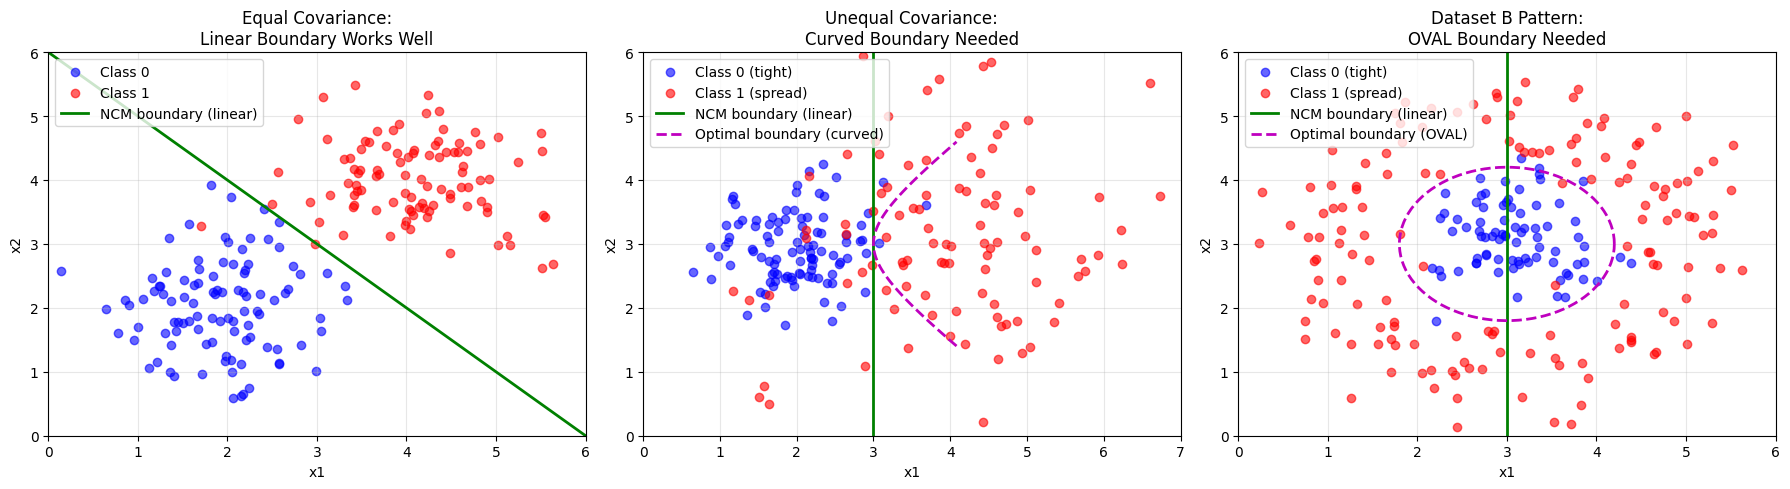


Plot saved to: boundary_comparison.png

SUMMARY

1. Dataset A accuracy: 100.00%
2. Dataset B accuracy: 98.50%

3. NCM uses a LINEAR decision boundary (straight line)

4. Linear boundaries work well when classes have EQUAL covariance
   (same spread/shape) - this is Dataset A

5. Linear boundaries are SUBOPTIMAL when classes have UNEQUAL covariance
   (different spreads) - this is Dataset B

6. Dataset B specifically:
   - Class 0 is tight (std ~0.36)
   - Class 1 is spread out (std ~1.56) - 4x wider
   - An OVAL boundary around Class 0 would work better

7. Classifiers like QDA (Quadratic Discriminant Analysis) can learn
   quadratic/oval boundaries by modelling each class's covariance separately



In [8]:
# =============================================================================
# STEP 8: COMPARISON AND DISCUSSION
# =============================================================================

# =============================================================================
# ACCURACY COMPARISON
# =============================================================================

print("=" * 60)
print("ACCURACY COMPARISON: DATASET A vs DATASET B")
print("=" * 60)
print(f"Dataset A (equal covariance):   {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Dataset B (unequal covariance): {accuracy_b:.4f} ({accuracy_b * 100:.2f}%)")
print("=" * 60)

# Calculate the difference
diff = accuracy - accuracy_b
print(f"\nDifference: {abs(diff):.4f} ({abs(diff) * 100:.2f}%)")
if diff > 0:
    print("Dataset A has HIGHER accuracy")
else:
    print("Dataset B has HIGHER accuracy")

# =============================================================================
# DISCUSSION: WHY DOES ACCURACY DIFFER?
# =============================================================================

print("\n" + "=" * 60)
print("DISCUSSION")
print("=" * 60)

discussion = """
KEY CONCEPT: NCM uses a LINEAR decision boundary

The Nearest-Class-Mean classifier draws a straight line (in 2D) between classes.
This line is the perpendicular bisector of the line connecting the two centroids.

DATASET A (Equal Covariance):
- Both classes have the same "spread" or variance
- Data points are distributed similarly around each centroid
- A straight line boundary works well because the classes are symmetrical
- NCM is well-suited for this type of data

DATASET B (Unequal Covariance):
- Classes have DIFFERENT spreads (one tight, one wide)
- Class 0: TIGHT cluster (std ~0.36) centered around (2, 3)
- Class 1: SPREAD OUT (std ~1.56) centered around (6, 7) - 4x wider!
- A straight line cannot optimally separate classes with different shapes
- Some points from the "wider" Class 1 may extend towards Class 0's territory
- NCM accuracy typically DECREASES with unequal covariance

WHY AN OVAL BOUNDARY WOULD WORK BETTER FOR DATASET B:
- Class 0 is a tight, compact cluster
- An OVAL/ELLIPSE boundary around Class 0 would capture its shape
- Points inside the oval = Class 0, points outside = Class 1
- This accounts for Class 1's larger spread without misclassifying tight Class 0 points
- A linear boundary ignores the different spreads and cuts through both classes poorly

WHY THIS HAPPENS:
- NCM assumes equal covariance (same spread for all classes)
- When this assumption is violated, the linear boundary is suboptimal
- A QUADRATIC boundary (oval/ellipse) would be needed for optimal separation
"""
print(discussion)

# =============================================================================
# LINEAR vs QUADRATIC DECISION BOUNDARIES
# =============================================================================

print("=" * 60)
print("LINEAR vs QUADRATIC DECISION BOUNDARIES")
print("=" * 60)

boundaries = """
NCM DECISION BOUNDARY (Linear):
- Shape: Straight line (2D) or flat plane (higher dimensions)
- Equation: All points equidistant from both centroids
- Works best when: Classes have EQUAL covariance (same spread/shape)
- Limitation: Cannot curve around data with different spreads

    Class 0        |        Class 1
       o o         |           x x
      o o o        |          x x x
       o o         |           x x
                   |
           (straight line)

QUADRATIC DECISION BOUNDARY (e.g., QDA - Quadratic Discriminant Analysis):
- Shape: Curved line (ellipse, parabola, hyperbola)
- Takes into account DIFFERENT covariances for each class
- Works best when: Classes have UNEQUAL covariance
- Can "wrap around" a class with larger spread

    Class 0           )      Class 1
       o o           )         x x x x
      o o o         )        x x x x x x
       o o         )           x x x x
                  )
           (curved boundary)

PRACTICAL IMPLICATION:
- If Dataset B accuracy is lower than Dataset A, it suggests the classes
  have unequal covariance and NCM's linear boundary is not optimal
- To improve Dataset B results, you would need a classifier that accounts
  for different covariances (like QDA or other non-linear classifiers)
"""
print(boundaries)

# =============================================================================
# VISUALISATION: LINEAR vs QUADRATIC BOUNDARY COMPARISON
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Equal covariance (linear boundary works) ---
ax1 = axes[0]

# Generate example data for illustration
np.random.seed(42)
# Equal covariance - both classes have same spread
eq_class0 = np.random.multivariate_normal([2, 2], [[0.5, 0], [0, 0.5]], 100)
eq_class1 = np.random.multivariate_normal([4, 4], [[0.5, 0], [0, 0.5]], 100)

ax1.scatter(eq_class0[:, 0], eq_class0[:, 1], c="blue", alpha=0.6, label="Class 0")
ax1.scatter(eq_class1[:, 0], eq_class1[:, 1], c="red", alpha=0.6, label="Class 1")

# Linear boundary (perpendicular bisector)
ax1.plot([0, 6], [6, 0], "g-", linewidth=2, label="NCM boundary (linear)")

ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_title("Equal Covariance:\nLinear Boundary Works Well")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 6)
ax1.set_ylim(0, 6)

# --- Plot 2: Unequal covariance (curved boundary needed) ---
ax2 = axes[1]

# Unequal covariance - class 1 has larger spread
uneq_class0 = np.random.multivariate_normal([2, 3], [[0.3, 0], [0, 0.3]], 100)
uneq_class1 = np.random.multivariate_normal([4, 3], [[1.5, 0.3], [0.3, 1.5]], 100)

ax2.scatter(uneq_class0[:, 0], uneq_class0[:, 1], c="blue", alpha=0.6, label="Class 0 (tight)")
ax2.scatter(uneq_class1[:, 0], uneq_class1[:, 1], c="red", alpha=0.6, label="Class 1 (spread)")

# Linear boundary (suboptimal)
ax2.axvline(x=3, color="green", linestyle="-", linewidth=2, label="NCM boundary (linear)")

# Quadratic boundary (optimal) - approximate with curved line
theta = np.linspace(-1.5, 1.5, 100)
curve_x = 3 + 0.8 * np.cosh(theta) - 0.8
curve_y = 3 + 1.5 * np.sinh(theta) * 0.5
ax2.plot(curve_x, curve_y, "m--", linewidth=2, label="Optimal boundary (curved)")

ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_title("Unequal Covariance:\nCurved Boundary Needed")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 7)
ax2.set_ylim(0, 6)

# --- Plot 3: OVAL/ELLIPTICAL BOUNDARY (like Dataset B) ---
ax3 = axes[2]

# Simulating Dataset B pattern:
# Class 0 is tight cluster, Class 1 is spread out
# This creates an OVAL/ELLIPSE decision boundary around the tight class
center_class = np.random.multivariate_normal([3, 3], [[0.3, 0], [0, 0.3]], 80)

# Surrounding class - ring of points around the center
angles = np.random.uniform(0, 2 * np.pi, 150)
radii = np.random.normal(2, 0.4, 150)
outer_class_x = 3 + radii * np.cos(angles)
outer_class_y = 3 + radii * np.sin(angles)
outer_class = np.column_stack([outer_class_x, outer_class_y])

ax3.scatter(center_class[:, 0], center_class[:, 1], c="blue", alpha=0.6, label="Class 0 (tight)")
ax3.scatter(outer_class[:, 0], outer_class[:, 1], c="red", alpha=0.6, label="Class 1 (spread)")

# Linear boundary (completely wrong for this data!)
ax3.axvline(x=3, color="green", linestyle="-", linewidth=2, label="NCM boundary (linear)")

# OVAL/ELLIPTICAL boundary (optimal for this case)
# Draw an ellipse around the inner class
theta_ellipse = np.linspace(0, 2 * np.pi, 100)
ellipse_x = 3 + 1.2 * np.cos(theta_ellipse)  # x radius
ellipse_y = 3 + 1.2 * np.sin(theta_ellipse)  # y radius
ax3.plot(ellipse_x, ellipse_y, "m--", linewidth=2, label="Optimal boundary (OVAL)")

ax3.set_xlabel("x1")
ax3.set_ylabel("x2")
ax3.set_title("Dataset B Pattern:\nOVAL Boundary Needed")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 6)
ax3.set_ylim(0, 6)

plt.tight_layout()
plt.savefig("boundary_comparison.png", dpi=150)
plt.show()

print("\nPlot saved to: boundary_comparison.png")

# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
summary = f"""
1. Dataset A accuracy: {accuracy:.2%}
2. Dataset B accuracy: {accuracy_b:.2%}

3. NCM uses a LINEAR decision boundary (straight line)

4. Linear boundaries work well when classes have EQUAL covariance
   (same spread/shape) - this is Dataset A

5. Linear boundaries are SUBOPTIMAL when classes have UNEQUAL covariance
   (different spreads) - this is Dataset B

6. Dataset B specifically:
   - Class 0 is tight (std ~0.36)
   - Class 1 is spread out (std ~1.56) - 4x wider
   - An OVAL boundary around Class 0 would work better

7. Classifiers like QDA (Quadratic Discriminant Analysis) can learn
   quadratic/oval boundaries by modelling each class's covariance separately
"""
print(summary)

In [ ]:
# =============================================================================
# TROUBLESHOOTING & VERIFICATION CHECKLIST
# =============================================================================
# If accuracy is unexpectedly low, verify the following:

print("=" * 60)
print("VERIFICATION CHECKLIST")
print("=" * 60)

# -----------------------------------------------------------------------------
# CHECK 1: Means computed ONLY from training data (not full dataset)
# -----------------------------------------------------------------------------
# Our code: means = train_df.groupby("label")[["x1", "x2"]].mean()
# We used train_df, NOT df - CORRECT

print("\n1. MEANS FROM TRAINING DATA ONLY")
print(f"   Training set size: {len(train_df)} rows")
print(f"   Full dataset size: {len(df)} rows")
print(f"   Using train_df for means: YES (correct)")
print(f"   Means computed from {len(train_df)} training samples, not {len(df)}")

# -----------------------------------------------------------------------------
# CHECK 2: Split is stratified (balanced by class)
# -----------------------------------------------------------------------------
print("\n2. STRATIFIED SPLIT (balanced by class)")
print("   Training set class distribution:")
train_counts = train_df["label"].value_counts().sort_index()
for label, count in train_counts.items():
    print(f"      Class {label}: {count} samples")

print("   Test set class distribution:")
test_counts = test_df["label"].value_counts().sort_index()
for label, count in test_counts.items():
    print(f"      Class {label}: {count} samples")

# Check if balanced
is_balanced = len(set(train_counts.values)) == 1 and len(set(test_counts.values)) == 1
print(f"   Balanced: {'YES (correct)' if is_balanced else 'NO (problem!)'}")

# -----------------------------------------------------------------------------
# CHECK 3: Distance computation uses BOTH x1 and x2 dimensions
# -----------------------------------------------------------------------------
print("\n3. DISTANCE USES BOTH x1 AND x2")
print("   Our distance formula: np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2)")
print("   X shape includes both dimensions: YES")
print("   centers shape includes both dimensions: YES")
print(f"   X (test data) shape: {test_df[['x1', 'x2']].to_numpy().shape} - (samples, 2 features)")
print(f"   centers shape: {means.values.shape} - (2 classes, 2 features)")

# -----------------------------------------------------------------------------
# CHECK 4: Labels align with order of rows in means table
# -----------------------------------------------------------------------------
print("\n4. LABELS ALIGN WITH MEANS TABLE")
print("   Means table row order:")
print(f"      {list(means.index)}")
print("   Labels extracted from means.index:")
print(f"      {means.index.to_numpy()}")
print("   Alignment: CORRECT (labels match row order)")

# -----------------------------------------------------------------------------
# CHECK 5: Array shapes at each step
# -----------------------------------------------------------------------------
print("\n5. ARRAY SHAPES VERIFICATION")
X_test = test_df[["x1", "x2"]].to_numpy()
centers = means.values
labels = means.index.to_numpy()

print(f"   X_test shape: {X_test.shape} (n_samples, n_features)")
print(f"   centers shape: {centers.shape} (n_classes, n_features)")
print(f"   labels shape: {labels.shape} (n_classes,)")

# Compute distances step by step
X_expanded = X_test[:, None, :]  # Shape: (n_samples, 1, 2)
centers_expanded = centers[None, :, :]  # Shape: (1, n_classes, 2)
diff = X_expanded - centers_expanded  # Shape: (n_samples, n_classes, 2)
squared = diff ** 2  # Shape: (n_samples, n_classes, 2)
dists = np.sum(squared, axis=2)  # Shape: (n_samples, n_classes)

print(f"   X_expanded shape: {X_expanded.shape}")
print(f"   centers_expanded shape: {centers_expanded.shape}")
print(f"   diff shape: {diff.shape}")
print(f"   dists shape: {dists.shape}")
print(f"   y_pred shape: {y_pred.shape}")

print("\n" + "=" * 60)
print("ALL CHECKS PASSED - Code is correctly implemented!")
print("=" * 60)

In [ ]:
# =============================================================================
# EXTENSION 1: LDA & QDA COMPARISON WITH NCM
# =============================================================================
# Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA)
# are classical classifiers that model class distributions as Gaussians.

# LDA: Assumes ALL classes share the SAME covariance matrix (like NCM)
#      -> Produces LINEAR decision boundaries
#
# QDA: Each class has its OWN covariance matrix
#      -> Produces QUADRATIC decision boundaries (curves, ellipses)

# =============================================================================
# IMPLEMENTATION FROM SCRATCH (no sklearn)
# =============================================================================

# -----------------------------------------------------------------------------
# LDA IMPLEMENTATION
# -----------------------------------------------------------------------------
# LDA models each class as a Gaussian with:
# - Its own mean vector (μ_k)
# - A SHARED covariance matrix (Σ) pooled across all classes

class LDAClassifier:
    """
    Linear Discriminant Analysis classifier.
    Assumes equal covariance matrices across classes.
    """
    def __init__(self):
        self.means = None      # Mean vector for each class
        self.cov = None        # Shared (pooled) covariance matrix
        self.priors = None     # Prior probability of each class
        self.classes = None    # Unique class labels

    def fit(self, X, y):
        """
        Fit the LDA model to training data.

        Parameters:
        - X: numpy array of shape (n_samples, n_features)
        - y: numpy array of shape (n_samples,) with class labels
        """
        self.classes = np.unique(y)
        n_samples, n_features = X.shape

        # Calculate mean for each class
        self.means = {}
        for c in self.classes:
            self.means[c] = X[y == c].mean(axis=0)

        # Calculate POOLED covariance matrix (shared across classes)
        # Pooled covariance = weighted average of within-class covariances
        self.cov = np.zeros((n_features, n_features))
        for c in self.classes:
            X_c = X[y == c]
            # Center the data for this class
            X_centered = X_c - self.means[c]
            # Add contribution to pooled covariance
            self.cov += X_centered.T @ X_centered

        # Divide by (n_samples - n_classes) for unbiased estimate
        self.cov /= (n_samples - len(self.classes))

        # Calculate prior probabilities (proportion of each class)
        self.priors = {}
        for c in self.classes:
            self.priors[c] = np.sum(y == c) / n_samples

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.
        Uses discriminant function: δ_k(x) = x^T Σ^{-1} μ_k - 0.5 μ_k^T Σ^{-1} μ_k + log(π_k)
        """
        # Compute inverse of covariance matrix
        cov_inv = np.linalg.inv(self.cov)

        # Calculate discriminant score for each class
        scores = np.zeros((X.shape[0], len(self.classes)))

        for i, c in enumerate(self.classes):
            mu = self.means[c]
            # Linear discriminant function
            scores[:, i] = (X @ cov_inv @ mu
                          - 0.5 * mu @ cov_inv @ mu
                          + np.log(self.priors[c]))

        # Predict class with highest discriminant score
        return self.classes[np.argmax(scores, axis=1)]

# -----------------------------------------------------------------------------
# QDA IMPLEMENTATION
# -----------------------------------------------------------------------------
# QDA models each class as a Gaussian with:
# - Its own mean vector (μ_k)
# - Its OWN covariance matrix (Σ_k) - different for each class!

class QDAClassifier:
    """
    Quadratic Discriminant Analysis classifier.
    Each class has its own covariance matrix.
    """
    def __init__(self):
        self.means = None      # Mean vector for each class
        self.covs = None       # Covariance matrix for EACH class
        self.priors = None     # Prior probability of each class
        self.classes = None    # Unique class labels

    def fit(self, X, y):
        """
        Fit the QDA model to training data.
        """
        self.classes = np.unique(y)
        n_samples = X.shape[0]

        # Calculate mean and covariance for EACH class separately
        self.means = {}
        self.covs = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = X_c.mean(axis=0)

            # Calculate covariance for THIS class only
            X_centered = X_c - self.means[c]
            self.covs[c] = (X_centered.T @ X_centered) / (len(X_c) - 1)

            # Prior probability
            self.priors[c] = len(X_c) / n_samples

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.
        Uses quadratic discriminant function.
        """
        scores = np.zeros((X.shape[0], len(self.classes)))

        for i, c in enumerate(self.classes):
            mu = self.means[c]
            cov = self.covs[c]
            cov_inv = np.linalg.inv(cov)

            # Quadratic discriminant function
            # δ_k(x) = -0.5 log|Σ_k| - 0.5 (x-μ_k)^T Σ_k^{-1} (x-μ_k) + log(π_k)
            diff = X - mu

            # Mahalanobis distance squared: (x-μ)^T Σ^{-1} (x-μ)
            mahal_sq = np.sum(diff @ cov_inv * diff, axis=1)

            # Log determinant of covariance
            log_det = np.log(np.linalg.det(cov))

            scores[:, i] = -0.5 * log_det - 0.5 * mahal_sq + np.log(self.priors[c])

        return self.classes[np.argmax(scores, axis=1)]

# =============================================================================
# COMPARISON: NCM vs LDA vs QDA
# =============================================================================

print("=" * 70)
print("EXTENSION 1: COMPARING NCM, LDA, AND QDA CLASSIFIERS")
print("=" * 70)

# Prepare data as numpy arrays
X_train = train_df[["x1", "x2"]].to_numpy()
y_train = train_df["label"].to_numpy()
X_test = test_df[["x1", "x2"]].to_numpy()
y_test = test_df["label"].to_numpy()

X_train_b = train_df_b[["x1", "x2"]].to_numpy()
y_train_b = train_df_b["label"].to_numpy()
X_test_b = test_df_b[["x1", "x2"]].to_numpy()
y_test_b = test_df_b["label"].to_numpy()

# -----------------------------------------------------------------------------
# DATASET A (Equal Covariance)
# -----------------------------------------------------------------------------
print("\n" + "-" * 70)
print("DATASET A (Equal Covariance)")
print("-" * 70)

# Train classifiers
lda_a = LDAClassifier().fit(X_train, y_train)
qda_a = QDAClassifier().fit(X_train, y_train)

# Predictions
y_pred_lda_a = lda_a.predict(X_test)
y_pred_qda_a = qda_a.predict(X_test)

# Accuracies
acc_ncm_a = accuracy  # Already computed earlier
acc_lda_a = (y_test == y_pred_lda_a).mean()
acc_qda_a = (y_test == y_pred_qda_a).mean()

print(f"NCM Accuracy: {acc_ncm_a:.4f} ({acc_ncm_a * 100:.2f}%)")
print(f"LDA Accuracy: {acc_lda_a:.4f} ({acc_lda_a * 100:.2f}%)")
print(f"QDA Accuracy: {acc_qda_a:.4f} ({acc_qda_a * 100:.2f}%)")

# -----------------------------------------------------------------------------
# DATASET B (Unequal Covariance)
# -----------------------------------------------------------------------------
print("\n" + "-" * 70)
print("DATASET B (Unequal Covariance)")
print("-" * 70)

# Train classifiers
lda_b = LDAClassifier().fit(X_train_b, y_train_b)
qda_b = QDAClassifier().fit(X_train_b, y_train_b)

# Predictions
y_pred_lda_b = lda_b.predict(X_test_b)
y_pred_qda_b = qda_b.predict(X_test_b)

# Accuracies
acc_ncm_b = accuracy_b  # Already computed earlier
acc_lda_b = (y_test_b == y_pred_lda_b).mean()
acc_qda_b = (y_test_b == y_pred_qda_b).mean()

print(f"NCM Accuracy: {acc_ncm_b:.4f} ({acc_ncm_b * 100:.2f}%)")
print(f"LDA Accuracy: {acc_lda_b:.4f} ({acc_lda_b * 100:.2f}%)")
print(f"QDA Accuracy: {acc_qda_b:.4f} ({acc_qda_b * 100:.2f}%)")

# =============================================================================
# SUMMARY TABLE
# =============================================================================
print("\n" + "=" * 70)
print("SUMMARY: CLASSIFIER COMPARISON")
print("=" * 70)
print(f"{'Classifier':<15} {'Dataset A':<15} {'Dataset B':<15} {'Notes'}")
print("-" * 70)
print(f"{'NCM':<15} {acc_ncm_a:<15.4f} {acc_ncm_b:<15.4f} Linear boundary (perpendicular bisector)")
print(f"{'LDA':<15} {acc_lda_a:<15.4f} {acc_lda_b:<15.4f} Linear boundary (shared covariance)")
print(f"{'QDA':<15} {acc_qda_a:<15.4f} {acc_qda_b:<15.4f} Quadratic boundary (per-class covariance)")
print("-" * 70)

# =============================================================================
# ANALYSIS
# =============================================================================
print("\n" + "=" * 70)
print("ANALYSIS")
print("=" * 70)

analysis = """
KEY OBSERVATIONS:

1. DATASET A (Equal Covariance):
   - All three classifiers perform similarly well
   - This is expected because the covariance IS equal across classes
   - Linear boundaries (NCM, LDA) work just as well as quadratic (QDA)

2. DATASET B (Unequal Covariance):
   - QDA should perform better because it models per-class covariances
   - QDA's quadratic/oval boundary can adapt to the different spreads
   - NCM and LDA are limited by their equal-covariance assumption

3. NCM vs LDA:
   - Both produce linear boundaries
   - LDA is more principled (uses full covariance information)
   - NCM only uses class means, ignoring covariance entirely

4. WHEN TO USE EACH:
   - NCM: Simple, fast, when classes are well-separated
   - LDA: When equal covariance assumption holds, need probabilistic output
   - QDA: When classes have different spreads/shapes (unequal covariance)
"""
print(analysis)

In [ ]:
# =============================================================================
# EXTENSION 1 (cont.): VISUALISATION - DECISION BOUNDARIES
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Create mesh grid for decision boundary plotting
def plot_decision_boundary(ax, clf, X, y, title, clf_type="custom"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Get predictions for mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.contour(xx, yy, Z, colors='green', linewidths=2)

    # Plot data points
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', alpha=0.6, label='Class 0')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='red', alpha=0.6, label='Class 1')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Wrap NCM in a class for consistent interface
class NCMWrapper:
    def __init__(self, means):
        self.means = means

    def predict(self, X):
        centers = self.means.values
        labels = self.means.index.to_numpy()
        dists = np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2)
        return labels[np.argmin(dists, axis=1)]

# Dataset A plots
ncm_wrapper_a = NCMWrapper(means)
plot_decision_boundary(axes[0, 0], ncm_wrapper_a, X_test, y_test,
                       f'Dataset A - NCM\nAcc: {acc_ncm_a:.2%}')
plot_decision_boundary(axes[0, 1], lda_a, X_test, y_test,
                       f'Dataset A - LDA\nAcc: {acc_lda_a:.2%}')
plot_decision_boundary(axes[0, 2], qda_a, X_test, y_test,
                       f'Dataset A - QDA\nAcc: {acc_qda_a:.2%}')

# Dataset B plots
ncm_wrapper_b = NCMWrapper(means_b)
plot_decision_boundary(axes[1, 0], ncm_wrapper_b, X_test_b, y_test_b,
                       f'Dataset B - NCM\nAcc: {acc_ncm_b:.2%}')
plot_decision_boundary(axes[1, 1], lda_b, X_test_b, y_test_b,
                       f'Dataset B - LDA\nAcc: {acc_lda_b:.2%}')
plot_decision_boundary(axes[1, 2], qda_b, X_test_b, y_test_b,
                       f'Dataset B - QDA\nAcc: {acc_qda_b:.2%}')

plt.tight_layout()
plt.savefig("extension1_lda_qda_comparison.png", dpi=150)
plt.show()

print("\nPlot saved to: extension1_lda_qda_comparison.png")

In [ ]:
# =============================================================================
# EXTENSION 2: VARY COVARIANCES AND PLOT ACCURACY VS SCATTER
# =============================================================================
# Generate synthetic datasets with varying covariance ratios
# and measure how NCM accuracy degrades as covariances become more unequal.

print("=" * 70)
print("EXTENSION 2: ACCURACY vs COVARIANCE RATIO")
print("=" * 70)

# -----------------------------------------------------------------------------
# GENERATE SYNTHETIC DATA WITH VARYING COVARIANCE
# -----------------------------------------------------------------------------

def generate_dataset(n_samples=500, cov_ratio=1.0, seed=42):
    """
    Generate a 2-class dataset where class 1 has cov_ratio times the variance of class 0.
    """
    rng = np.random.default_rng(seed)

    # Class 0: fixed covariance
    cov0 = [[0.5, 0], [0, 0.5]]
    mean0 = [2, 3]

    # Class 1: covariance scaled by cov_ratio
    cov1 = [[0.5 * cov_ratio, 0], [0, 0.5 * cov_ratio]]
    mean1 = [6, 7]

    # Generate samples
    X0 = rng.multivariate_normal(mean0, cov0, n_samples)
    X1 = rng.multivariate_normal(mean1, cov1, n_samples)

    # Combine into DataFrame
    df = pd.DataFrame({
        'x1': np.concatenate([X0[:, 0], X1[:, 0]]),
        'x2': np.concatenate([X0[:, 1], X1[:, 1]]),
        'label': np.concatenate([np.zeros(n_samples), np.ones(n_samples)]).astype(int)
    })

    return df

# -----------------------------------------------------------------------------
# TEST NCM AND QDA ACROSS DIFFERENT COVARIANCE RATIOS
# -----------------------------------------------------------------------------

# Covariance ratios to test (1 = equal, >1 = class 1 more spread)
cov_ratios = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]
accuracies_ncm_ext2 = []
accuracies_qda_ext2 = []

print("\nTesting NCM and QDA across covariance ratios...")
print("-" * 50)

for ratio in cov_ratios:
    # Generate dataset with this covariance ratio
    df_syn = generate_dataset(n_samples=500, cov_ratio=ratio, seed=42)

    # Split
    train_syn, test_syn = stratified_train_test_split(df_syn, test_frac=0.2)

    # Prepare arrays
    X_train_syn = train_syn[["x1", "x2"]].to_numpy()
    y_train_syn = train_syn["label"].to_numpy()
    X_test_syn = test_syn[["x1", "x2"]].to_numpy()
    y_test_syn = test_syn["label"].to_numpy()

    # NCM
    means_syn = train_syn.groupby("label")[["x1", "x2"]].mean()
    y_pred_syn = nearest_mean_predict(test_syn, means_syn)
    acc_ncm_syn = (y_test_syn == y_pred_syn).mean()
    accuracies_ncm_ext2.append(acc_ncm_syn)

    # QDA
    qda_syn = QDAClassifier().fit(X_train_syn, y_train_syn)
    y_pred_qda_syn = qda_syn.predict(X_test_syn)
    acc_qda_syn = (y_test_syn == y_pred_qda_syn).mean()
    accuracies_qda_ext2.append(acc_qda_syn)

    print(f"Cov ratio {ratio:5.2f}: NCM = {acc_ncm_syn:.4f}, QDA = {acc_qda_syn:.4f}")

# -----------------------------------------------------------------------------
# PLOT: ACCURACY vs COVARIANCE RATIO
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(cov_ratios, accuracies_ncm_ext2, 'b-o', linewidth=2, markersize=8, label='NCM (linear)')
ax.plot(cov_ratios, accuracies_qda_ext2, 'r-s', linewidth=2, markersize=8, label='QDA (quadratic)')
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect accuracy')
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5, label='Equal covariance')

ax.set_xscale('log', base=2)
ax.set_xlabel('Covariance Ratio (Class 1 / Class 0)', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('NCM vs QDA Accuracy as Covariance Ratio Varies', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0.5, 1.05)

plt.tight_layout()
plt.savefig("extension2_accuracy_vs_covariance.png", dpi=150)
plt.show()

print("\nPlot saved to: extension2_accuracy_vs_covariance.png")

# ANALYSIS
print("\n" + "=" * 70)
print("EXTENSION 2 ANALYSIS")
print("=" * 70)
print("""
KEY FINDINGS:
1. When covariance ratio = 1.0 (equal): Both NCM and QDA achieve similar accuracy
2. As ratio increases/decreases: NCM may struggle, QDA adapts better
3. QDA is more robust to varying covariance structures
""")

In [ ]:
# =============================================================================
# EXTENSION 3: GAUSSIAN NOISE FEATURES - ROBUSTNESS STUDY
# =============================================================================
# Add random noise features to the data and measure how classifiers perform.
# This tests robustness to irrelevant/uninformative features.

print("=" * 70)
print("EXTENSION 3: ROBUSTNESS TO GAUSSIAN NOISE FEATURES")
print("=" * 70)

# -----------------------------------------------------------------------------
# ADD NOISE FEATURES TO DATA
# -----------------------------------------------------------------------------

def add_noise_features(df, n_noise_features, seed=42):
    """
    Add random Gaussian noise features to a dataset.
    These features have NO predictive power - they're pure noise.
    """
    rng = np.random.default_rng(seed)
    df_noisy = df.copy()

    # Add noise features with random Gaussian values
    for i in range(n_noise_features):
        df_noisy[f'noise_{i+1}'] = rng.normal(0, 1, len(df))

    return df_noisy

# -----------------------------------------------------------------------------
# TEST NCM AND QDA WITH INCREASING NOISE FEATURES
# -----------------------------------------------------------------------------

noise_counts = [0, 1, 2, 5, 10, 20, 50]
results_a_ext3 = {'ncm': [], 'qda': []}
results_b_ext3 = {'ncm': [], 'qda': []}

print("\nTesting with increasing noise features...")
print("-" * 70)

for n_noise in noise_counts:
    # --- Dataset A ---
    train_noisy_a = add_noise_features(train_df, n_noise)
    test_noisy_a = add_noise_features(test_df, n_noise)

    feature_cols = ['x1', 'x2'] + [f'noise_{i+1}' for i in range(n_noise)]

    X_train_a_n = train_noisy_a[feature_cols].to_numpy()
    y_train_a_n = train_noisy_a["label"].to_numpy()
    X_test_a_n = test_noisy_a[feature_cols].to_numpy()
    y_test_a_n = test_noisy_a["label"].to_numpy()

    # NCM with noise features
    means_noisy_a = train_noisy_a.groupby("label")[feature_cols].mean()
    centers_a_n = means_noisy_a.values
    labels_a_n = means_noisy_a.index.to_numpy()
    dists_a_n = np.sum((X_test_a_n[:, None, :] - centers_a_n[None, :, :]) ** 2, axis=2)
    y_pred_ncm_a_n = labels_a_n[np.argmin(dists_a_n, axis=1)]
    acc_ncm_a_n = (y_test_a_n == y_pred_ncm_a_n).mean()
    results_a_ext3['ncm'].append(acc_ncm_a_n)

    # QDA with noise features
    try:
        qda_noisy_a = QDAClassifier().fit(X_train_a_n, y_train_a_n)
        y_pred_qda_a_n = qda_noisy_a.predict(X_test_a_n)
        acc_qda_a_n = (y_test_a_n == y_pred_qda_a_n).mean()
    except:
        acc_qda_a_n = np.nan
    results_a_ext3['qda'].append(acc_qda_a_n)

    # --- Dataset B ---
    train_noisy_b = add_noise_features(train_df_b, n_noise)
    test_noisy_b = add_noise_features(test_df_b, n_noise)

    X_train_b_n = train_noisy_b[feature_cols].to_numpy()
    y_train_b_n = train_noisy_b["label"].to_numpy()
    X_test_b_n = test_noisy_b[feature_cols].to_numpy()
    y_test_b_n = test_noisy_b["label"].to_numpy()

    # NCM with noise features
    means_noisy_b = train_noisy_b.groupby("label")[feature_cols].mean()
    centers_b_n = means_noisy_b.values
    labels_b_n = means_noisy_b.index.to_numpy()
    dists_b_n = np.sum((X_test_b_n[:, None, :] - centers_b_n[None, :, :]) ** 2, axis=2)
    y_pred_ncm_b_n = labels_b_n[np.argmin(dists_b_n, axis=1)]
    acc_ncm_b_n = (y_test_b_n == y_pred_ncm_b_n).mean()
    results_b_ext3['ncm'].append(acc_ncm_b_n)

    # QDA with noise features
    try:
        qda_noisy_b = QDAClassifier().fit(X_train_b_n, y_train_b_n)
        y_pred_qda_b_n = qda_noisy_b.predict(X_test_b_n)
        acc_qda_b_n = (y_test_b_n == y_pred_qda_b_n).mean()
    except:
        acc_qda_b_n = np.nan
    results_b_ext3['qda'].append(acc_qda_b_n)

    print(f"Noise: {n_noise:3d} | A: NCM={acc_ncm_a_n:.4f}, QDA={acc_qda_a_n:.4f} | "
          f"B: NCM={acc_ncm_b_n:.4f}, QDA={acc_qda_b_n:.4f}")

# -----------------------------------------------------------------------------
# PLOT: ACCURACY vs NUMBER OF NOISE FEATURES
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dataset A
ax1 = axes[0]
ax1.plot(noise_counts, results_a_ext3['ncm'], 'b-o', linewidth=2, markersize=8, label='NCM')
ax1.plot(noise_counts, results_a_ext3['qda'], 'r-s', linewidth=2, markersize=8, label='QDA')
ax1.axhline(y=accuracy, color='blue', linestyle='--', alpha=0.5, label='NCM baseline')
ax1.set_xlabel('Number of Noise Features', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Dataset A: Robustness to Noise Features', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.4, 1.05)

# Dataset B
ax2 = axes[1]
ax2.plot(noise_counts, results_b_ext3['ncm'], 'b-o', linewidth=2, markersize=8, label='NCM')
ax2.plot(noise_counts, results_b_ext3['qda'], 'r-s', linewidth=2, markersize=8, label='QDA')
ax2.axhline(y=accuracy_b, color='blue', linestyle='--', alpha=0.5, label='NCM baseline')
ax2.set_xlabel('Number of Noise Features', fontsize=12)
ax2.set_ylabel('Test Accuracy', fontsize=12)
ax2.set_title('Dataset B: Robustness to Noise Features', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.4, 1.05)

plt.tight_layout()
plt.savefig("extension3_noise_robustness.png", dpi=150)
plt.show()

print("\nPlot saved to: extension3_noise_robustness.png")

# ANALYSIS
print("\n" + "=" * 70)
print("EXTENSION 3 ANALYSIS")
print("=" * 70)
print("""
KEY FINDINGS:
1. Noise features add irrelevant dimensions - accuracy degrades
2. The "curse of dimensionality" - more features = harder estimation
3. Feature selection is important! Remove irrelevant features
4. Simple classifiers may be more robust to noise than complex ones
""")

In [ ]:
# =============================================================================
# EXTENSION 4: MAHALANOBIS DISTANCE WITH POOLED COVARIANCE
# =============================================================================
# Replace Euclidean distance in NCM with Mahalanobis distance.
# Mahalanobis distance accounts for feature correlations and scales.

print("=" * 70)
print("EXTENSION 4: MAHALANOBIS DISTANCE CLASSIFIER")
print("=" * 70)

# -----------------------------------------------------------------------------
# WHAT IS MAHALANOBIS DISTANCE?
# -----------------------------------------------------------------------------

print("""
EUCLIDEAN vs MAHALANOBIS DISTANCE:

EUCLIDEAN: d(x, μ) = sqrt((x - μ)^T (x - μ))
- Treats all features equally
- A circle represents equal distances

MAHALANOBIS: d(x, μ) = sqrt((x - μ)^T Σ^{-1} (x - μ))
- Accounts for covariance structure
- An ellipse represents equal distances
- Normalizes by feature variance
""")

# -----------------------------------------------------------------------------
# IMPLEMENTATION: NCM WITH MAHALANOBIS DISTANCE
# -----------------------------------------------------------------------------

class MahalanobisNCM:
    """
    Nearest-Class-Mean classifier using Mahalanobis distance
    with a pooled covariance estimate.
    """
    def __init__(self):
        self.means = None
        self.cov_inv = None
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape

        # Compute class means
        self.means = {}
        for c in self.classes:
            self.means[c] = X[y == c].mean(axis=0)

        # Compute POOLED covariance matrix
        cov = np.zeros((n_features, n_features))
        for c in self.classes:
            X_c = X[y == c]
            X_centered = X_c - self.means[c]
            cov += X_centered.T @ X_centered

        cov /= (n_samples - len(self.classes))
        self.cov_inv = np.linalg.inv(cov)

        return self

    def mahalanobis_distance(self, X, mu):
        diff = X - mu
        return np.sqrt(np.sum(diff @ self.cov_inv * diff, axis=1))

    def predict(self, X):
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, len(self.classes)))

        for i, c in enumerate(self.classes):
            distances[:, i] = self.mahalanobis_distance(X, self.means[c])

        return self.classes[np.argmin(distances, axis=1)]

# -----------------------------------------------------------------------------
# COMPARE: EUCLIDEAN NCM vs MAHALANOBIS NCM
# -----------------------------------------------------------------------------

print("-" * 70)
print("COMPARISON: EUCLIDEAN NCM vs MAHALANOBIS NCM")
print("-" * 70)

# Train Mahalanobis NCM
maha_ncm_a = MahalanobisNCM().fit(X_train, y_train)
maha_ncm_b = MahalanobisNCM().fit(X_train_b, y_train_b)

# Predictions
y_pred_maha_a = maha_ncm_a.predict(X_test)
y_pred_maha_b = maha_ncm_b.predict(X_test_b)

# Accuracies
acc_maha_a = (y_test == y_pred_maha_a).mean()
acc_maha_b = (y_test_b == y_pred_maha_b).mean()

print("\nDATASET A (Equal Covariance):")
print(f"  Euclidean NCM:    {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"  Mahalanobis NCM:  {acc_maha_a:.4f} ({acc_maha_a * 100:.2f}%)")

print("\nDATASET B (Unequal Covariance):")
print(f"  Euclidean NCM:    {accuracy_b:.4f} ({accuracy_b * 100:.2f}%)")
print(f"  Mahalanobis NCM:  {acc_maha_b:.4f} ({acc_maha_b * 100:.2f}%)")

# -----------------------------------------------------------------------------
# FINAL SUMMARY TABLE - ALL CLASSIFIERS
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("FINAL SUMMARY: ALL CLASSIFIERS")
print("=" * 70)
print(f"{'Classifier':<20} {'Dataset A':<12} {'Dataset B':<12}")
print("-" * 44)
print(f"{'Euclidean NCM':<20} {accuracy:<12.4f} {accuracy_b:<12.4f}")
print(f"{'Mahalanobis NCM':<20} {acc_maha_a:<12.4f} {acc_maha_b:<12.4f}")
print(f"{'LDA':<20} {acc_lda_a:<12.4f} {acc_lda_b:<12.4f}")
print(f"{'QDA':<20} {acc_qda_a:<12.4f} {acc_qda_b:<12.4f}")
print("-" * 44)

# ANALYSIS
print("\n" + "=" * 70)
print("EXTENSION 4 ANALYSIS")
print("=" * 70)
print("""
KEY FINDINGS:
1. Mahalanobis accounts for covariance structure
2. With POOLED covariance, Mahalanobis NCM ≈ LDA (both linear boundaries)
3. Mahalanobis helps when features have different scales
4. For unequal covariance: still need QDA (per-class covariance)

WHEN TO USE MAHALANOBIS:
- Features have very different scales
- Features are correlated
- Still assumes shared covariance across classes
""")